In [1]:
path = "recordings/20-11-24--16-26-08"

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

900.11


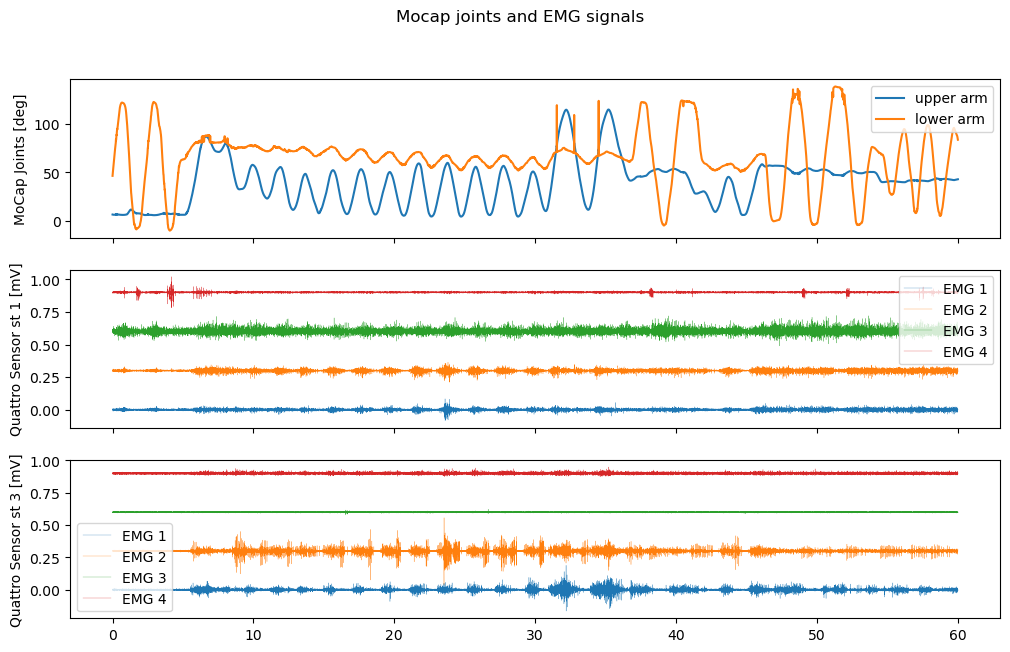

In [3]:
from Plotter import plot_dataset, plot_joints
fig = plt.figure(figsize=(12, 7))
fig.suptitle("Mocap joints and EMG signals")
plot_dataset(path, (True, False, False, True), t_crop=(10, 70), fig=fig)

## How to handle leaps in the data

900.11


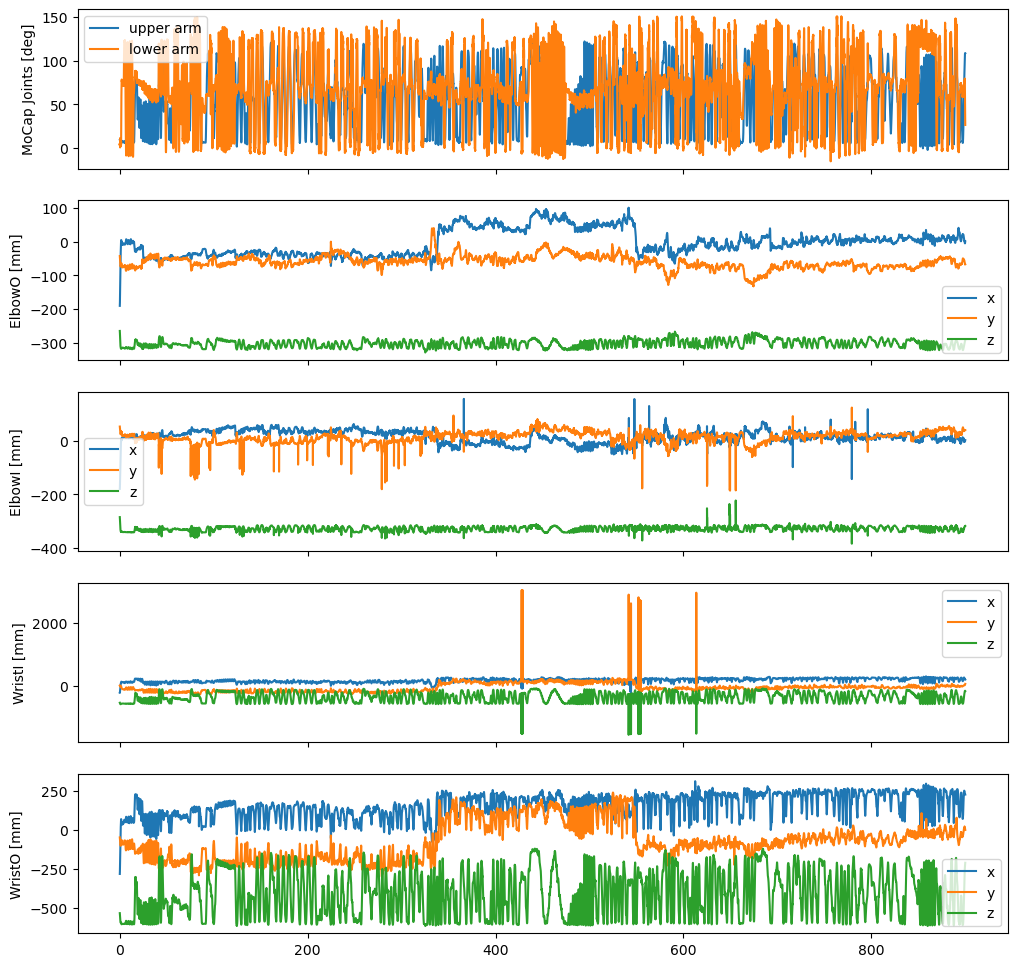

In [4]:
fig = plt.figure(figsize=(12, 12))
plot_dataset(path, (True, False, True, False), 
             fig=fig, markers=("ElbowO", "ElbowI", "WristI", "WristO"), 
            # t_crop=(130, 230)
            )

In [5]:
from utils import read_mocap_joints, read_mocap_marker, read_mocap_setup
from operator import itemgetter

joint_data = read_mocap_joints(path)["joints"]
joint_data = np.where(joint_data == -999, np.nan, joint_data) # where important markers were predicted
marker_pred, marker = itemgetter("marker_prediction", "mocap")(read_mocap_marker(path))

In [6]:
marker_labels = [x[0] for x in read_mocap_setup(path)["Markers"]]
marker_labels

['ShoulderB',
 'ShoulderF',
 'ElbowO',
 'UpperArm',
 'ElbowI',
 'WristO',
 'WristI',
 'LowerArm1',
 'LowerArm2',
 'WristL',
 'Hand']

## Filter Using Markers

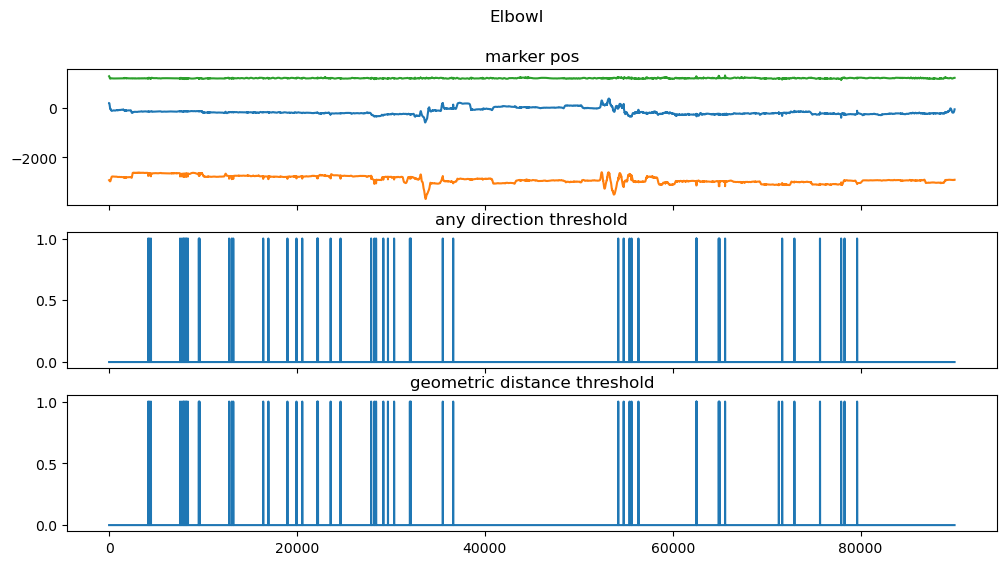

In [7]:
i = 4
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
fig.suptitle(marker_labels[i])
axs[0].plot(marker[:, i, :])
axs[1].plot(np.any(np.diff(marker, axis=0)[:, i, :] > 50, axis=1))
axs[2].plot(np.sqrt(np.sum((marker[1:, :, :] - marker[:-1,:,:])**2, axis=2))[:,i] > 50)
axs[0].set_title("marker pos")
axs[1].set_title("any direction threshold")
axs[2].set_title("geometric distance threshold")
plt.show()

## Filter using Calculated joints directly

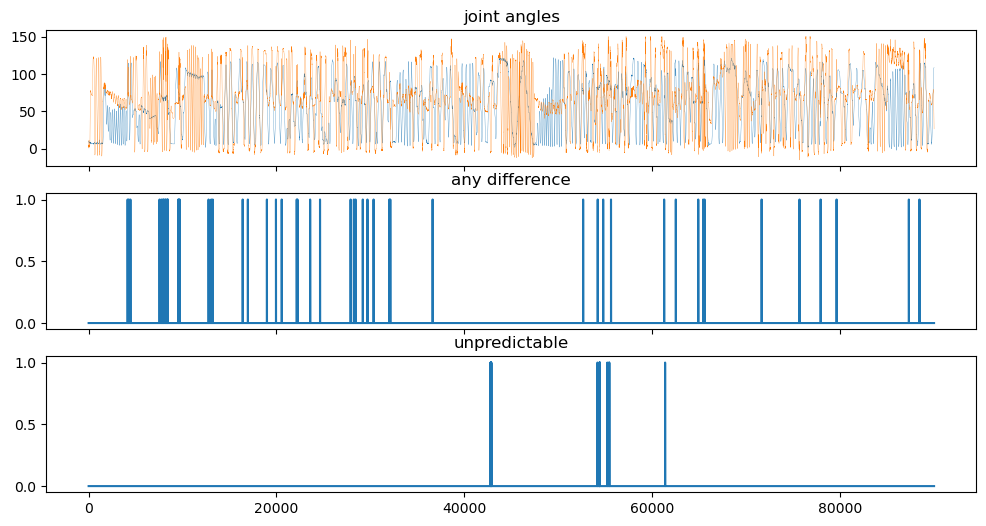

In [8]:
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
axs[0].plot(joint_data, lw=0.2)
axs[1].plot(np.any(np.diff(joint_data, axis=0) > 20, axis=1))
axs[2].plot(np.any(marker_pred == 0, axis=1))
axs[0].set_title("joint angles")
axs[1].set_title("any difference")
axs[2].set_title("unpredictable")
plt.show()

-2:     no need to predict as marker is only for redundancy \
-1:     predicted \
0:      unable to predict or occluded \
1:      not occluded \

## Combine all

In [9]:
imp_marker_idx = [0, 1, 2, 4, 5, 6]

In [10]:
mask = (
    np.any(np.sqrt(np.sum((marker[1:, :, :] - marker[:-1,:,:])**2, axis=2))[:, imp_marker_idx] > 50, axis=1) | 
    np.any(marker_pred[:-1] == 0, axis=1) |
    np.any(np.diff(joint_data, axis=0) > 30, axis=1)
)
mask = np.where(mask)[0]
mask

array([ 4152,  4153,  4275,  4276,  4449,  4450,  7550,  7551,  7751,
        7754,  7911,  7913,  7994,  7997,  8145,  8148,  8237,  8240,
        8390,  8392,  8425,  8430,  9548,  9553,  9616,  9620,  9690,
        9691, 12771, 12772, 13056, 13057, 13214, 13215, 16402, 16403,
       16954, 16955, 18980, 18982, 19945, 19946, 20558, 20559, 22155,
       22157, 22234, 22235, 23584, 23585, 24636, 24638, 27892, 27893,
       28240, 28241, 28419, 28420, 29189, 29191, 29685, 29686, 30338,
       30339, 32021, 32022, 32117, 32120, 35523, 35524, 36623, 36630,
       42781, 42782, 42783, 42788, 42789, 42791, 42792, 42795, 42796,
       42797, 42798, 42799, 42805, 42806, 42807, 42808, 42809, 42815,
       42816, 42817, 42819, 42820, 42825, 42826, 42827, 42828, 42829,
       42830, 42831, 42832, 42833, 42847, 42848, 42849, 42850, 42852,
       42853, 42854, 42856, 42857, 42863, 42864, 52632, 52648, 54174,
       54175, 54198, 54199, 54201, 54203, 54381, 54382, 54384, 54385,
       54393, 54394,

In [11]:
mask = [0] + list(mask) + [joint_data.shape[0]]
bundles = []
for i, diff in enumerate(np.diff(mask)):
    if diff > 1000: 
        bundles.append(joint_data[mask[i] + 1: mask[i+1] - 1, :])

In [12]:
print(sum([b.shape[0] for b in bundles]), joint_data.shape[0], len(bundles))

77539 90011 27


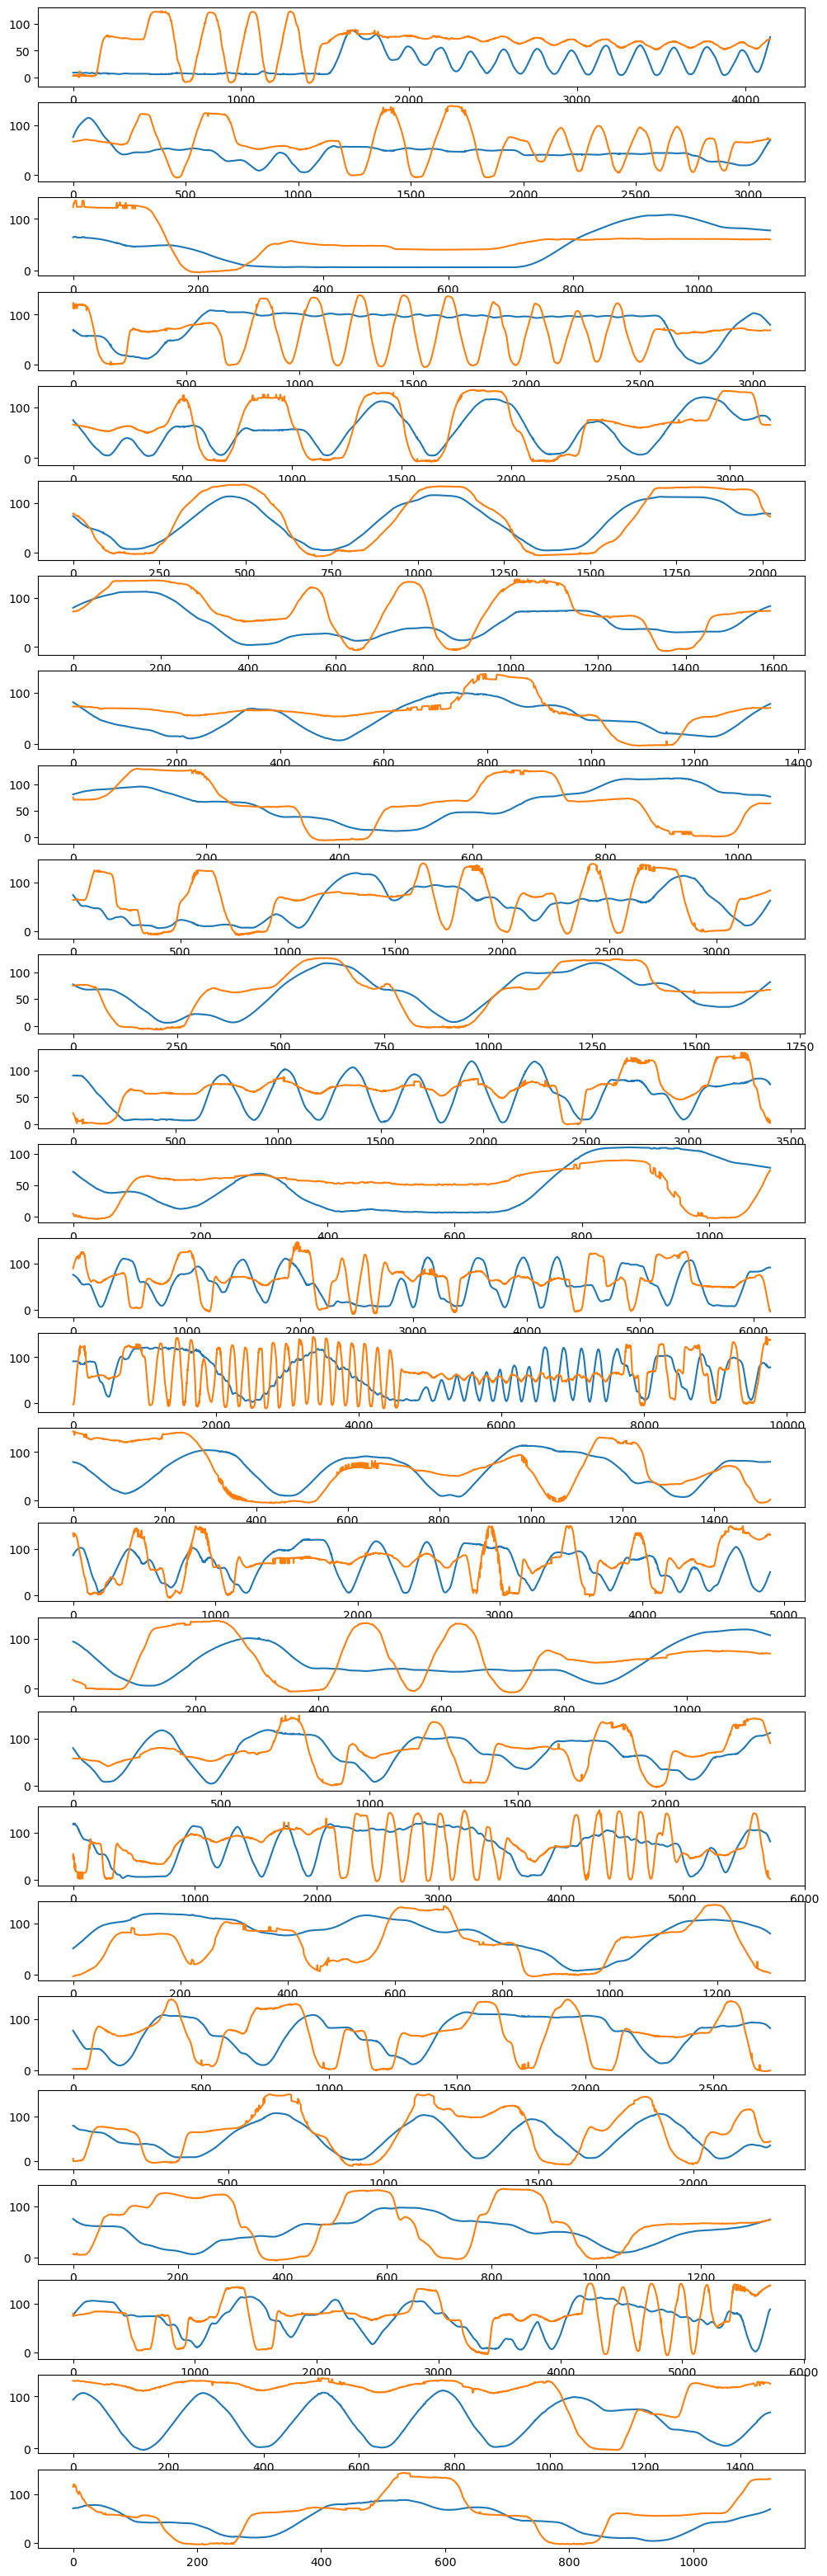

In [13]:
fig, axs = plt.subplots(len(bundles), figsize=(12, 40))
for (ax, bundle) in zip(axs, bundles): 
    ax.plot(bundle)